In [1]:
%matplotlib widget

In [2]:
import numpy as np
import xtrack as xt
import matplotlib.pyplot as plt

In [3]:
env = xt.Environment()
env.call('../fccee_z_lattice.py')
env.call('../002_design_optics/quad_strength_limits.py')

env.call('../002_design_optics/matching_constraints.py')

In [4]:
line = -env['ccs_yl']

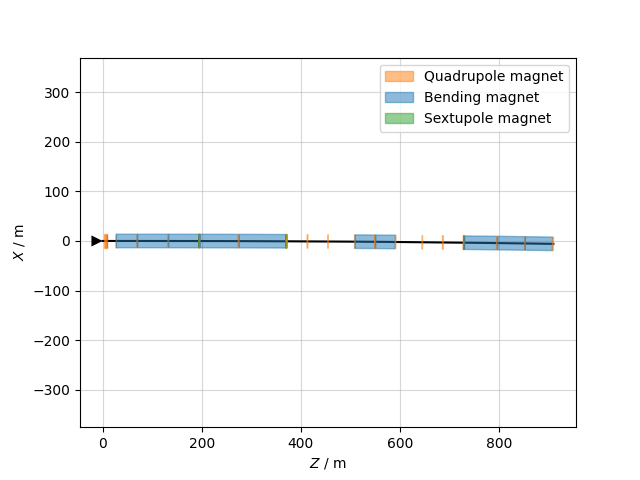

In [5]:
line.survey().plot()

In [6]:
kq_doublet = ['kqd0al', 'kqd0bl', 'kqf1al']
kq_section_a = ['kqd01l', 'kqf02l', 'kqd02l']
kq_section_b = ['kqd04l', 'kqf05l', 'kqd06l']
kq_yquads = ['kqy01l', 'kqy02l', 'kqy03l', 'kqy04l']

In [7]:
# Initialize quadrupoles with a small strength
for nn in kq_doublet + kq_section_a + kq_section_b +kq_yquads:
    if line.vars.vary_default[nn]['limits'][1] > 1e-3: # Focusing quad
        line[nn] = 1e-3
    else: # Defocusing quad
        line[nn] = -1e-3

In [8]:
opt_doublet = line.match(
    name='doublet',
    solve=False,
    betx=env['bxip'],
    bety=env['byip'],
    targets=[
        # Peak in the doublet
        xt.TargetSet(bety=xt.LessThan(8550), at='qd0bl'),
        # Doublet exit
        xt.TargetSet(bety=xt.LessThan(3500), at='qf1bl'),
        xt.TargetSet(bety=xt.GreaterThan(3300), at='qf1bl'),
        # First quadrupole downstream
        xt.TargetSet(betx=xt.GreaterThan(1300), at='qd1l'),
        xt.TargetSet(betx=xt.LessThan(1400), at='qd1l'),
        xt.TargetSet(bety=xt.LessThan(3200), at='qd1l'),
        xt.TargetSet(bety=xt.GreaterThan(3100), at='qd1l'),
    ],
    vary = xt.VaryList(kq_doublet, step=1e-8)
)
opt = opt_doublet
opt.step(100)

                                             
Optimize [doublet] - start penalty: 1.004e+06
Matching: model call n. 45               
Optimize [doublet] - end penalty:     0


(<xtrack.twissplot.TwissPlot object at 0x33f5ea350>,
 <xtrack.twissplot.TwissPlot object at 0x33f5ea350>)

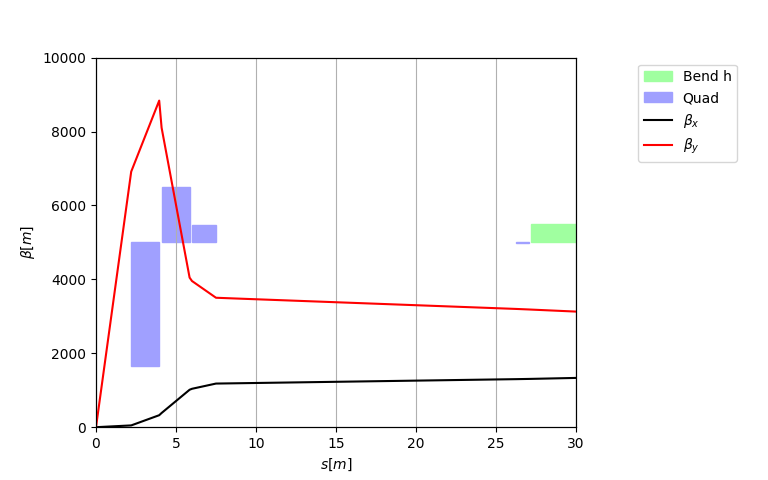

In [9]:
pp=opt.plot('betx bety')
pp.xlim(0, 30), pp.ylim(left_lo=0, left_hi=10000)

### Match section A (up to the first sextupole - sdm1l)

In [10]:
opt_sdm1l = opt_doublet.clone(
    name='sdm1l', remove_vary=True,
    add_targets=[
        xt.TargetSet(betx=xt.LessThan(10.), bety=xt.LessThan(12.),
                         alfx=xt.GreaterThan(-1.), alfy=0.0,
                         at='sdm1l::0'),
        xt.TargetSet(betx=xt.LessThan(3000), at='qf2l'),
        xt.TargetSet(bety=xt.GreaterThan(900), at='qf2l'),
    ], 
    add_vary=xt.VaryList(kq_section_a, step=1e-8),
)
opt = opt_sdm1l
opt.step(100)

                                             
Optimize [sdm1l] - start penalty: 3079  
Matching: model call n. 749               
Optimize [sdm1l] - end penalty:  0.629113


In [11]:
opt.target_status()

Target status:                            
id state tag           tol_met       residue   current_val target_val        description                                 
0  ON    qd0bl_bety       True             0       8102.49 LessThan(8550)    ('bety', 'qd0bl'), val=LessThan(8550), t ...
1  ON    qf1bl_bety       True             0       3499.99 LessThan(3500)    ('bety', 'qf1bl'), val=LessThan(3500), t ...
2  ON    qf1bl_bety       True             0       3499.99 GreaterThan(3300) ('bety', 'qf1bl'), val=GreaterThan(3300) ...
3  ON    qd1l_betx        True             0          1300 GreaterThan(1300) ('betx', 'qd1l'), val=GreaterThan(1300), ...
4  ON    qd1l_betx        True             0          1300 LessThan(1400)    ('betx', 'qd1l'), val=LessThan(1400), to ...
5  ON    qd1l_bety        True             0       3199.95 LessThan(3200)    ('bety', 'qd1l'), val=LessThan(3200), to ...
6  ON    qd1l_bety        True             0       3199.95 GreaterThan(3100) ('bety', 'qd1l'), val=Grea

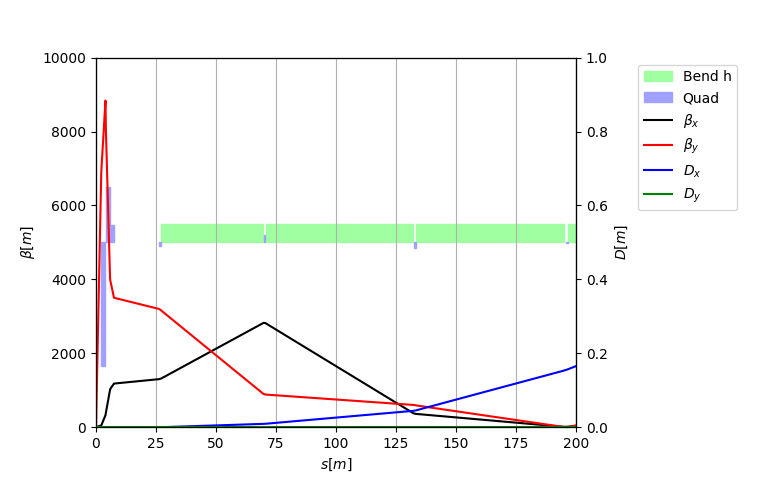

In [12]:
pp=opt.plot()
pp.xlim(0, 200); pp.ylim(0, 1e4, 0, 1)

### Match section B (up to second sextupole `sdy1l::1`)

In [13]:
# First we use only quadrupoles in section B
opt_dsdy1l = opt_sdm1l.clone(
    name='sdy1l', 
    remove_targets=True, remove_vary=True,
    add_targets=xt.TargetSet(at='sdy1l::1',
        bety=8114.3, betx=371.7,
        alfy=0., dx=xt.GreaterThan(0.3),
        muy=0.75 + env['dmuy_sdy1l']),
    add_vary=xt.VaryList(kq_section_b, step=1e-8))
opt = opt_dsdy1l
opt.step(100)

                                             
Optimize [sdy1l] - start penalty: 3492  
Matching: model call n. 695               
Optimize [sdy1l] - end penalty:  995.938


In [14]:
# Then we use also the quadrupoles in section A
opt_dsdy1l_refine = opt_dsdy1l.clone(name='dsdy1l_refine',
                    add_vary=xt.VaryList(kq_section_a, step=1e-8))
opt = opt_dsdy1l_refine
opt.step(100)

                                             
Optimize [dsdy1l_refine] - start penalty: 995.9
Matching: model call n. 985               
Optimize [dsdy1l_refine] - end penalty:  1.14762e-08


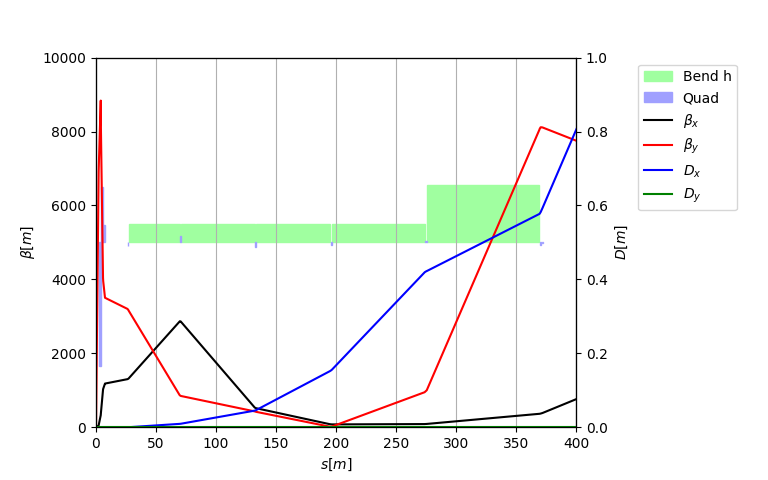

In [15]:
pp = opt.plot()
pp.xlim(0, 400); pp.ylim(0, 1e4, 0, 1)

### Create a -I transformation between `sdy1l` and `sdy2l`

In [16]:
opt_rsext = line.match(
    name='rmat_sext',
    solve=False,
    start='sdy1l::1', end='sdy2l::1', init_at='ipimag2',
    betx=135, bety=10, # Rough estimate
    targets=xt.TargetRmatrix(start='sdy1l::1', end='sdy2l::1',
                r12=env['r12_ccsyl'], r34=env['r34_ccsyl'],
                r33=-1.0, r43=0.0, tol=1e-6),
    vary=xt.VaryList(kq_yquads, step=1e-8)
)

opt = opt_rsext
opt.disable(target=True)
opt.enable(target=0)
opt.step(20)
opt.enable(target=1)
opt.step(20)
opt.enable(target=2)
opt.step(20)
opt.enable(target=3)
opt.step(20)

                                             
Optimize [rmat_sext] - start penalty: 346.7
Matching: model call n. 31               
Optimize [rmat_sext] - end penalty:  1.08275e-06
                                             
Optimize [rmat_sext] - start penalty: 8.871
Matching: model call n. 69               
Optimize [rmat_sext] - end penalty:  7.2164e-07
                                             
Optimize [rmat_sext] - start penalty: 436.8
Matching: model call n. 113               
Optimize [rmat_sext] - end penalty:  7.2606e-06
                                             
Optimize [rmat_sext] - start penalty: 7.281e-06
Matching: model call n. 120               
Optimize [rmat_sext] - end penalty:  2.00327e-09


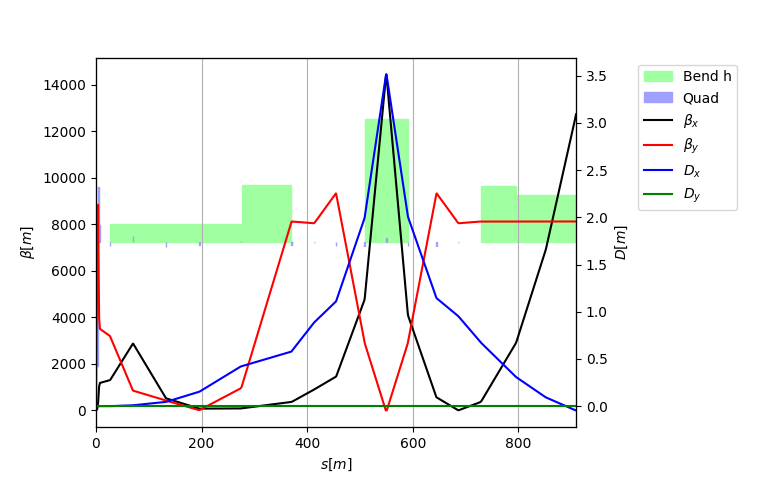

In [17]:
opt_dsdy1l.plot()

### Control beta end dispersion at IP image point
(preserving all conditions matched so far)